Running...
Still running...
Still running...
Real 1


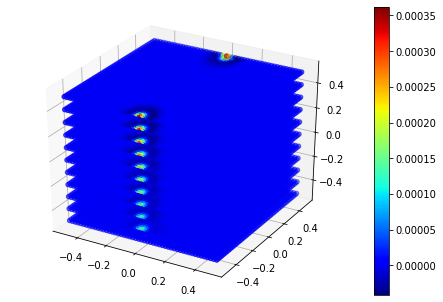

Real 2


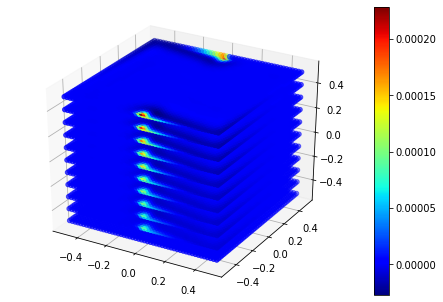

Imaginary 1


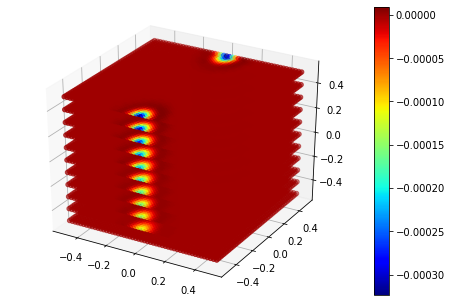

Imaginary 2


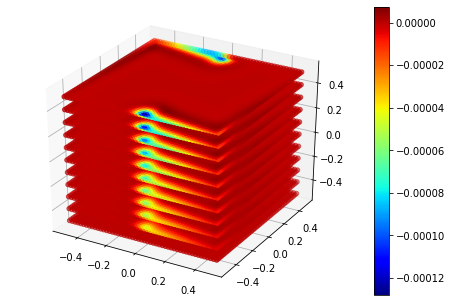

Real 2D 1


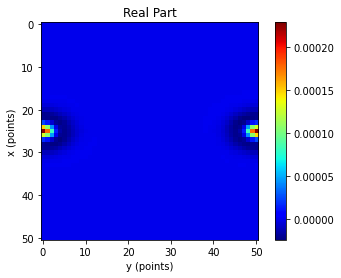

<Figure size 432x288 with 0 Axes>

Real 2D 2


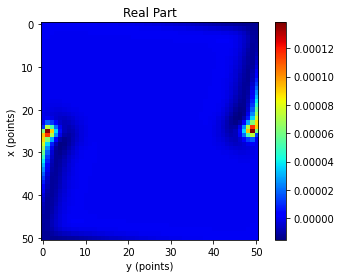

<Figure size 432x288 with 0 Axes>

Imaginary 2D 1


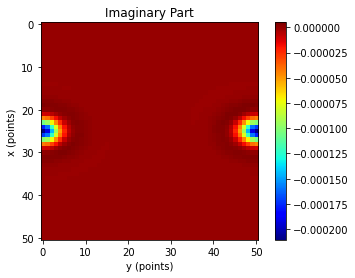

<Figure size 432x288 with 0 Axes>

Imaginary 2D 2


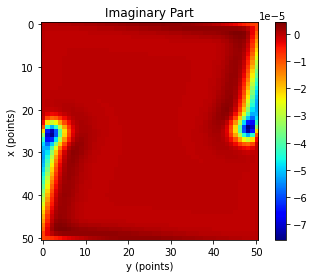

<Figure size 432x288 with 0 Axes>

Phase Plots


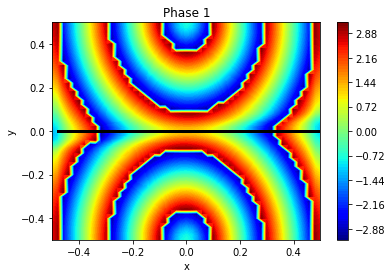

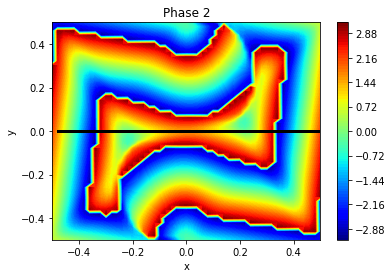

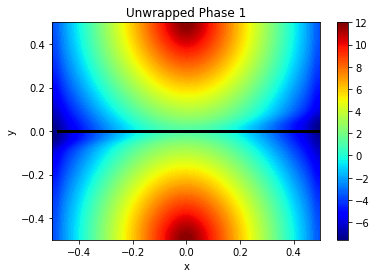

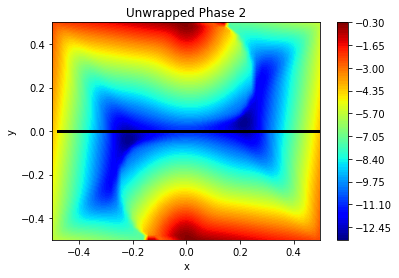

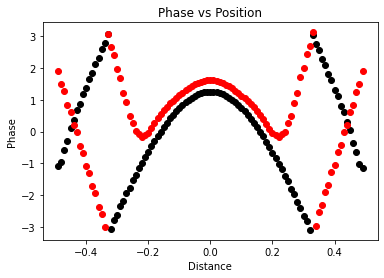

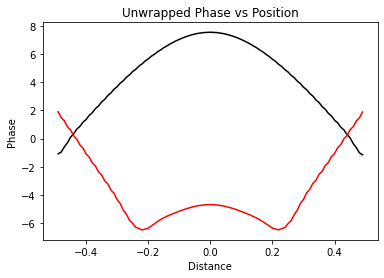

Max phase 1 (black) = 7.534532982400358 radians occurs at distance = [0.]
Max phase 2 (red) = 1.9025461135222743 radians occurs at distance = [-0.49]


In [5]:
#Include an off diagonal term in the diffusivity matrix (Dxy)
#Measure phase in a circle around the heat source (radius of circle is a variable)
#Look for phase shift when Dxy is nonzero by setting Dx not equal to Dy 
#No phase shift near the beam becuase Dxy and Dyx terms cancel out (if Dxy = -Dyx)
from dolfin import *
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from skimage import data, img_as_float, color, exposure
from skimage.restoration import unwrap_phase
from scipy.optimize import curve_fit
import pylab as plt

radius = .2
spacing = .01
depth = 1
omega = 1000
n=1
tol = 1E-14
#Dx = omega/(2*36*np.pi**2)
Dx = .5
Dy = 1
Dz = 1
#Set Dxy1 near 0 for reference
Dxy1 = 0.0001
Dyx1 = - Dxy1
#Set Dxy2 as a nonzero value 
Dxy2 = 5
Dyx2 = - Dxy2
theta = 0
#umax = 2*np.pi*n
#xmax = umax*np.sqrt(2/omega)
truexc = 0
trueyc = .5
xcenter = truexc/np.sqrt(Dx)
ycenter = trueyc/np.sqrt(Dy)

#xcenter = truexc
#ycenter = trueyc
truex = 1
truey = 1
truez = 1
xmax = truex/np.sqrt(Dx)
ymax = truey/np.sqrt(Dy)
zmax = truez/np.sqrt(Dz)
#xmax = truex
#ymax = truey
#zmax = truez
xpoints = 50
ypoints = 50
zpoints = 10
rdefect = .01
#xspace = .1
#yspace = .1
ndefectx = 5
ndefecty = 4

#Dmatrix = np.matrix([[Dx, 0 ,0], [0, Dy, 0], [0, 0, Dz]])
#Dmatrix = np.matrix('Dx, 0, 0; 0, Dy, 0; 0, 0, Dz')

def solver(g, xmax, ymax, zmax, tol, mesh, omega, alpha, Dxy, Dxx, Dyy):
    
    #(ureal, uimag, sigma, mu) = TrialFunctions(W)
    #(v1, v2, v3, v4) = TestFunctions(W)
    (ureal, uimag) = TrialFunctions(W)
    (v1, v2) = TestFunctions(W)

    #a = (dot(grad(uimag),grad(v1)) + omega/alpha*ureal*v1 + omega/alpha*uimag*v2 - dot(grad(ureal),grad(v2)) + sigma*v3 + dot(grad(ureal), grad(v3)) + mu*v4 + dot(grad(uimag), grad(v4)))*dx 
    #a = (dot(np.matmul(Dmatrix, grad(uimag)),grad(v1)) + omega*ureal*v1 + omega*uimag*v2 - dot(np.matmul(Dmatrix, grad(ureal)),grad(v2)))*dx

    a = (alpha*dot(grad(uimag),grad(v1)) + omega*ureal*v1 + omega*uimag*v2 - alpha*dot(grad(ureal),grad(v2)))*dx + (Dxy/np.sqrt(Dxx*Dyy)*alpha*uimag.dx(1)*v1.dx(0) - Dxy/np.sqrt(Dxx*Dyy)*alpha*uimag.dx(0)*v1.dx(1) - Dxy/np.sqrt(Dxx*Dyy)*alpha*ureal.dx(1)*v2.dx(0) + Dxy/np.sqrt(Dxx*Dyy)*alpha*ureal.dx(0)*v2.dx(1))*dx



    #a = (dot(Dmatrix*grad(uimag),grad(v1)) + omega*ureal*v1 + omega*uimag*v2 - dot(Dmatrix*grad(ureal),grad(v2)))*dx
    L =  - g*v2*dx
    
    def bot(x, on_boundary): return on_boundary and near(x[2], -zmax/2, tol)
    noslip = Constant(0.0)
    bc0 = DirichletBC(W.sub(0), noslip, bot)
    bc1 = DirichletBC(W.sub(1), noslip, bot)
    G = Expression('0', degree = 0)
    def boundary(x, on_boundary):
            return on_boundary and not near(x[2], -zmax/2, tol)    
    #bc2 = DirichletBC(W.sub(2), G, boundary)
    #bc3 = DirichletBC(W.sub(3), G, boundary)
    bcs = [bc0, bc1]

    w = Function(W)
    solve(a == L, w, bcs, solver_parameters={'linear_solver':'mumps'})
    
    (ureal, uimag) = w.split()
    
    return ureal, uimag

def phasef(ureal, uimag, xline, yline, depth, z):
    
    zpoints = len(z)

    wtot = 0
    upointr = 0
    upointi = 0
    #utoti = np.zeros(cutnumy*cutnumx)
    for i in range(0,zpoints):
    
        uliner = ureal(xline,yline,z[i])
        ulinei = uimag(xline,yline,z[i])
    
        wlayer = np.exp(z[i]/depth)#/ np.sum()
        wtot = wtot + wlayer
        upointr = upointr + uliner*wlayer
        upointi = upointi + ulinei*wlayer
        #utotr = utotr + u_sheetr * wlayer
        #utoti = utoti + u_sheeti * wlayer
    
    upointr = upointr/wtot
    upointi = upointi/wtot
    #print(' ')
    #print(upointr)
    #print(upointi)
    phase = np.arctan2(upointi, upointr)
    #print(phase)
    return phase

def linepoints(theta, truexc, trueyc, truex, truey, truez, spacing):
    d = 0.0
    listpoints = np.array([[d, truexc, trueyc]])
    lookright = True 
    while lookright:
        d = d+spacing
        xtemp = truexc + np.cos(theta)*d
        ytemp = trueyc + np.sin(theta)*d
        if xtemp > truex/2 or ytemp > truey/2 or xtemp < -truex/2 or ytemp < -truey/2:
            lookright = False
        else:
            listpoints = np.append(listpoints,[[d, xtemp, ytemp]], axis = 0)
    lookleft = True
    d = 0
    while lookleft:
        d = d - spacing
        xtemp = truexc + np.cos(theta)*d
        ytemp = trueyc + np.sin(theta)*d
        if xtemp > truex/2 or ytemp > truey/2 or xtemp < -truex/2 or ytemp < -truey/2:
            lookleft = False
        else:
            listpoints = np.append([[d, xtemp, ytemp]],listpoints, axis = 0)
    return listpoints
    
def checkradius(radius, truxc, trueyc, truex, truey, x, y):
    if (radius + truexc) > truex/2 or (radius + trueyc) > truey/2 or (radius - truexc) < -truex/2 or (radius - trueyc) < -truey/2:
            radius = min(np.array([truex/2 - truexc, truey/2 - trueyc]))
            print('Radius changed to fall within boundary')
            print('Radius = ' + str(radius))
    rpoints = np.zeros(2)
    xr = np.array([0])
    yr = np.array([0])
    #print(np.shape(rpoints))
    thetal = np.linspace(0, 2*np.pi, 1000)
    for i in range (0, len(thetal)):
        theta = thetal[i]
        xpoint = radius*np.cos(theta) + truexc
        ypoint = radius*np.sin(theta) + trueyc
        #rpoints = np.append(rpoints, [xpoint, ypoint], axis = 1)
        xr = np.append(xr, xpoint)
        yr = np.append(yr, ypoint)
    return radius, xr, yr, thetal

def phaseline(ureal, uimag, xline, yline, depth, z):
    phasearray = np.zeros(len(xline))
    for i in range(0, len(xline)):
        phasearray[i] = phasef(ureal, uimag, xline[i], yline[i], depth, z)
     
    return phasearray
    
def phasecirc(ureal, uimag, xr, yr, depth, z):
    phasearray = np.zeros(len(xr)-1)
    for i in range(1, len(xr)):
        phasearray[i-1] = phasef(ureal, uimag, xr[i], yr[i], depth, z)
    return phasearray

def utotal(cutnumx, cutnumy, x, y, z, zpoints, ureal, uimag, depth): 
    wtot = 0
    utotr = np.zeros(cutnumy*cutnumx)
    utoti = np.zeros(cutnumy*cutnumx)
    for i in range(0,zpoints):
    
        points = [(x_, y_, z[i]) for x_ in x for y_ in y]
        u_sheetr = np.array([ureal(point) for point in points])
        u_sheeti = np.array([uimag(point) for point in points])
    
        wlayer = np.exp(z[i]/depth)#/ np.sum()
        wtot = wtot + wlayer
    
        utotr = utotr + u_sheetr * wlayer
        utoti = utoti + u_sheeti * wlayer
    
    utotr = utotr/wtot
    utoti = utoti/wtot

    utotr = np.reshape(utotr, (cutnumx, cutnumy))
    utoti = np.reshape(utoti, (cutnumx, cutnumy))

    return utotr, utoti

def scatter3d(meshpts, u):
    meshpts = mesh.coordinates()
    uarray = np.array([u(Point(x,y,z)) for x,y,z in meshpts])
    xdata = meshpts[:,0]
    xdata = np.transpose(xdata)
    ydata = meshpts[:,1]
    ydata = np.transpose(ydata)
    zdata = meshpts[:,2]
    zdata = np.transpose(zdata)
    cm = plt.get_cmap('jet')
    cNorm = matplotlib.colors.Normalize(vmin=min(uarray), vmax=max(uarray))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(xdata, ydata, zdata, c=scalarMap.to_rgba(uarray))
    scalarMap.set_array(uarray)
    fig.colorbar(scalarMap)
    plt.show()

print('Running...')

xdefect = np.linspace(-truex/2, truex/2, ndefectx)/np.sqrt(Dx)
ydefect = np.linspace(-truey/2, truey/2, ndefecty)/np.sqrt(Dy)

e = .1
beta = .89

density = (xpoints*ypoints*zpoints)/(truex*truey*truez)

p0 = Point (-xmax/2, -ymax/2, -zmax/2)
p1 = Point (xmax/2, ymax/2, zmax/2)
mesh = BoxMesh(p0, p1, xpoints, ypoints, zpoints)

CG1_elem = FiniteElement("CG", mesh.ufl_cell(), 1)
CG2_elem = FiniteElement("CG", mesh.ufl_cell(), 1)
#CG3_elem = FiniteElement("CG", mesh.ufl_cell(), 1)
#CG4_elem = FiniteElement("CG", mesh.ufl_cell(), 1)

W_elem = MixedElement([CG1_elem, CG2_elem])
W = FunctionSpace(mesh, W_elem)

qtot = Expression('1', degree = 2)

for i in range(0, len(xdefect)):
    for j in range(0, len(ydefect)):
        ydefectj = ydefect[j]
        xdefecti = xdefect[i]
        qtemp = Expression('1 - beta*((x[0] - xdefecti)*(x[0] - xdefecti) + (x[1] - ydefectj)*(x[1] - ydefectj) < rdefect)', degree = 2, xdefecti = xdefecti, ydefectj = ydefectj, rdefect = rdefect, beta = beta)
        qtot = qtot * qtemp 
        
#alpha1 = qtot   
alpha1 = 1
#alpha2 = 1

ktrue = 1000
#kx = ktrue
kx = ktrue
ky = ktrue

xcenter2 = 0
ycenter2 = -.5

#f = Expression('(-b*b - 4*kx*kx*(x[0] - xcenter)*(x[0] - xcenter) + 2*kx - 4*ky*ky*(x[1] - ycenter)*(x[1] - ycenter) + 2*ky)*exp(b*(x[2] - top/2) - kx*(x[0]-xcenter)*(x[0]-xcenter) - ky*(x[1]-ycenter)*(x[1]-ycenter))', degree = 2, kx = kx, ky = ky, b = 1, top = zmax/2, xcenter = xcenter, ycenter = ycenter, omega = omega)
g = Expression('exp(b*(x[2] - top/2) - kx*(x[0]-xcenter)*(x[0]-xcenter) - ky*(x[1]-ycenter)*(x[1]-ycenter)) + exp(b*(x[2] - top/2) - kx*(x[0]-xcenter2)*(x[0]-xcenter2) - ky*(x[1]-ycenter2)*(x[1]-ycenter2))', degree = 2, kx = kx, ky = ky, b = 1, top = zmax/2, xcenter = xcenter, ycenter = ycenter, xcenter2 = xcenter2, ycenter2 = ycenter2)

ureal1, uimag1 = solver(g, xmax, ymax, zmax, tol, mesh, omega, alpha1, Dxy1, Dx, Dy)

print('Still running...')

ureal2, uimag2 = solver(g, xmax, ymax, zmax, tol, mesh, omega, alpha1, Dxy2, Dx, Dy)

print('Still running...')

meshpts = mesh.coordinates()
meshpts[:, 0] *= np.sqrt(Dx)
meshpts[:, 1] *= np.sqrt(Dy)
meshpts[:, 2] *= np.sqrt(Dz)

cutnumy = xpoints+1
cutnumx = ypoints+1
cutnumz = zpoints+1

xn = -truex/2
xp = truex/2
zn = -truez/2
zp = truez/2
yp = truey/2
yn = -truey/2

y = np.linspace(yn + tol, yp - tol, cutnumy)
x = np.linspace(xn + tol, xp - tol, cutnumx)
z = np.linspace(zn + tol, zp - tol, cutnumz)

utotr1, utoti1 = utotal(cutnumx, cutnumy, x, y, z, zpoints, ureal1, uimag1, depth)
utotr2, utoti2 = utotal(cutnumx, cutnumy, x, y, z, zpoints, ureal2, uimag2, depth)

print('Real 1')
scatter3d(meshpts, ureal1)
print('Real 2')
scatter3d(meshpts, ureal2)
print('Imaginary 1')
scatter3d(meshpts, uimag1)
print('Imaginary 2')
scatter3d(meshpts, uimag2)

print('Real 2D 1')

plt.imshow(utotr1, cmap = cmx.jet)
plt.colorbar()
plt.title('Real Part')
plt.xlabel('y (points)')
plt.ylabel('x (points)')
plt.figure()
plt.show()

print('Real 2D 2')

plt.imshow(utotr2, cmap = cmx.jet)
plt.colorbar()
plt.title('Real Part')
plt.xlabel('y (points)')
plt.ylabel('x (points)')
plt.figure()
plt.show()

print('Imaginary 2D 1')

plt.imshow(utoti1, cmap = cmx.jet)
plt.colorbar()
plt.title('Imaginary Part')
plt.xlabel('y (points)')
plt.ylabel('x (points)')
plt.figure()
plt.show()

print('Imaginary 2D 2')

plt.imshow(utoti2, cmap = cmx.jet)
plt.colorbar()
plt.title('Imaginary Part')
plt.xlabel('y (points)')
plt.ylabel('x (points)')
plt.figure()
plt.show()

tan1 = np.arctan2(utoti1, utotr1)
tan2 = np.arctan2(utoti2, utotr2)

print('Phase Plots')

#plt.imshow(tan1, cmap = cmx.jet)
#plt.colorbar()
#plt.title('Phase')
#plt.xlabel('y (points)')
#plt.ylabel('x (points)')
#plt.figure()
#plt.savefig('/Users/tiffpaul/Desktop/PhaseFig.png')
#plt.show()

testline = linepoints(theta, truexc, 0, truex, truey, truez, spacing)
#print(testline)
#radius1, xr, yr, thetal  = checkradius(radius, truexc, trueyc, truex, truey, x, y)


distance = testline[:, 0]
xline = testline[:, 1]
yline = testline[:, 2]

phasearray1 = phaseline(ureal1, uimag1, xline, yline, depth, z)
phasearray2 = phaseline(ureal2, uimag2, xline, yline, depth, z)
#circle1 = phasecirc(ureal1, uimag1, xr, yr, depth, z)
#circle2 = phasecirc(ureal2, uimag2, xr, yr, depth, z)

xv, yv = np.meshgrid(x, y)
fig = plt.gcf()
plt.contourf(xv, yv, np.transpose(tan1), 100, cmap = cmx.jet)
plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
plt.colorbar()
plt.title('Phase 1')
plt.xlabel('x')
plt.ylabel('y')
#fig.set_size_inches(8, truey/truex*8)
plt.show()

fig = plt.gcf()
plt.contourf(xv, yv, np.transpose(tan2), 100, cmap = cmx.jet)
plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
plt.colorbar()
plt.title('Phase 2')
plt.xlabel('x')
plt.ylabel('y')
#fig.set_size_inches(8, truey/truex*8)
plt.show()

image_unwrapped1 = unwrap_phase(np.transpose(tan1))
fig = plt.gcf()
plt.contourf(xv, yv, image_unwrapped1, 100, cmap = cmx.jet)
plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
plt.colorbar()
plt.title('Unwrapped Phase 1')
plt.xlabel('x')
plt.ylabel('y')
#fig.set_size_inches(8, truey/truex*8)
plt.show()

image_unwrapped2 = unwrap_phase(np.transpose(tan2))
fig = plt.gcf()
plt.contourf(xv, yv, image_unwrapped2, 100, cmap = cmx.jet)
plt.plot(xline[1:], yline[1:], c = 'black', linewidth = 3)
plt.colorbar()
plt.title('Unwrapped Phase 2')
plt.xlabel('x')
plt.ylabel('y')
#fig.set_size_inches(8, truey/truex*8)
plt.show()

#circle1 = phasecirc(ureal1, uimag1, xr, yr, depth, z)
#circle2 = phasecirc(ureal2, uimag2, xr, yr, depth, z)

plt.scatter(distance, phasearray1, c = 'black')
plt.scatter(distance, phasearray2, c = 'red')

plt.title('Phase vs Position')
plt.xlabel('Distance')
plt.ylabel('Phase')
plt.show()

image1 = phasearray1
image_unwrapped1 = np.unwrap(image1)
plt.plot(distance, image_unwrapped1, c = 'black')

image2 = phasearray2
image_unwrapped2 = np.unwrap(image2)
plt.plot(distance, image_unwrapped2, c = 'red')
plt.title('Unwrapped Phase vs Position')
plt.xlabel('Distance')
plt.ylabel('Phase')
plt.show()

#plt.scatter(thetal, circle1, c = 'black')
#plt.scatter(thetal, circle2, c = 'red')

#plt.title('Phase at R')
#plt.xlabel('Theta (radians)')
#plt.ylabel('Phase')
#plt.show()

#image1 = circle1
#image_unwrapped1 = np.unwrap(image1)
#image2 = circle2
#image_unwrapped2 = np.unwrap(image2)
#plt.plot(thetal, image_unwrapped1, c = 'black')
#plt.plot(thetal, image_unwrapped2, c = 'red')

#plt.title('Unwrapped Phase at R')
#plt.xlabel('Theta (radians)')
#plt.ylabel('Phase')
#plt.show()

max_value1 = np.amax(image_unwrapped1)
#max_index1 = image_unwrapped1.index(max_value1)
in1 = np.where(image_unwrapped1 == np.amax(image_unwrapped1))
#max_index1 = in1[0]
max_value2 = np.amax(image_unwrapped2)
#max_index2 = image_unwrapped2.index(max_value2)
in2 = np.where(image_unwrapped2 == np.amax(image_unwrapped2))
print('Max phase 1 (black) = ' + str(np.amax(image_unwrapped1)) + ' radians occurs at distance = ' + str(distance[in1[0]]))
print('Max phase 2 (red) = ' + str(np.amax(image_unwrapped2)) + ' radians occurs at distance = ' + str(distance[in2[0]]))
#print('Difference in these theta values = ' + str(thetal[in2[0]] - thetal[in1[0]]) + ' radians')
#Curve fits?
#guess_freq1 = 2
#guess_amplitude1 = 3*np.std(image_unwrapped1)/(2**0.5)
#guess_phase1 = 0
#guess_offset1 = np.mean(image_unwrapped1)

#guess_freq2 = 2
#guess_amplitude2 = 3*np.std(image_unwrapped2)/(2**0.5)
#guess_phase2 = 0
#guess_offset2 = np.mean(image_unwrapped2)

#p01=[guess_freq1, guess_amplitude1,
    #guess_phase1, guess_offset1]

#p02=[guess_freq2, guess_amplitude2,
    #guess_phase2, guess_offset2]

# create the function we want to fit
#def my_sin(x, freq, amplitude, phase, offset):
    #return np.sin(x * freq + phase) * amplitude + offset

# now do the fit
#fit1 = curve_fit(my_sin, thetal, image_unwrapped1, p0=p01)
#print(fit1[0])
#popt1  = fit1[0]
#print(popt1[2])
#fitphase1 = popt1[2]
#print('Fit 1 parameters: freq, amp, phase, offset')
#print(fit1[0])
#print('Uncertainty')
#print(fit1[1])
#perr1 = np.sqrt(np.diag(fit1[1]))
#print(perr1)
#print(perr1[2])
#fit2 = curve_fit(my_sin, thetal, image_unwrapped2, p0=p02)
#print(fit2[0])
#print('Fit 2 parameters: freq, amp, phase, offset')
#print(fit2[0])
#popt2 = fit2[0]
#fitphase2 = popt2[2]
#print('Uncertainty')
#print(fit1[1])
#perr2 = np.sqrt(np.diag(fit2[1]))
#print(perr2)

#fitphasedif = fitphase2-fitphase1
#print('Difference in sine fit phase parameters = ' + str(fitphasedif) + ' radians')

# we'll use this to plot our first estimate. This might already be good enough for you
#data_first_guess1 = my_sin(thetal, *p01)
#data_first_guess2 = my_sin(thetal, *p02)

# recreate the fitted curve using the optimized parameters
#data_fit1 = my_sin(thetal, *fit1[0])
#data_fit2 = my_sin(thetal, *fit2[0])

#plt.plot(thetal, image_unwrapped1, label='phase 1', c = 'black')
#plt.plot(thetal, image_unwrapped2, label='phase 2', c = 'red')

#plt.plot(thetal, data_fit1, label='fit 1', c = 'green')
#plt.plot(thetal, data_fit2, label='fit 2', c = 'blue')
#plt.legend()
#plt.xlabel('Theta (radians)')
#plt.ylabel('Phase')
#plt.show()

#diff = image_unwrapped2-image_unwrapped1
#plt.plot(thetal, diff, label='point by point', c = 'black')
#plt.plot(thetal, data_fit2 - data_fit1, label='fit diff', c = 'orange')
#plt.title('Difference in Unwrapped Phase at R')
#plt.xlabel('Theta (radians)')
#plt.ylabel('Difference in Phase')
#plt.legend()
#plt.show()
